In [153]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
import pandas as pd
from IPython.display import clear_output
import scipy.sparse as sp
import plotly.graph_objects as go

In [2]:
# os.chdir("G:\Mon Drive\M2\PGM\Wikipedia-Clustering")

In [3]:
graph_df = pd.read_csv("./data/small_graphs/squirrel/musae_squirrel_edges.csv")
names = pd.read_csv('./data/wiki-topcats-page-names.txt.gz', compression='gzip', header=None, sep='\t', quotechar='"')

squirells = nx.from_pandas_edgelist(graph_df, source="id1", target="id2")

In [4]:
print(squirells)
nodes = squirells.nodes()
n = squirells.number_of_nodes()

Graph with 5201 nodes and 198493 edges


In [5]:
nodes = list(nodes)
print([[node] for node in nodes])

[[3475], [2849], [3106], [808], [4555], [3563], [1527], [3327], [402], [4066], [3908], [2820], [4903], [715], [5112], [817], [4855], [5057], [4481], [3975], [2408], [2539], [4236], [3372], [4303], [4658], [3829], [5078], [313], [4410], [777], [3609], [5122], [4650], [5093], [4862], [2930], [169], [5067], [3700], [2238], [2890], [4544], [2371], [5123], [1481], [1039], [3668], [1654], [1883], [4796], [2173], [3644], [4664], [1316], [4965], [5194], [2219], [3630], [3603], [3253], [3413], [4989], [2972], [5074], [2958], [3691], [4419], [5125], [3909], [4346], [5196], [4365], [3852], [4847], [3730], [3891], [4434], [4730], [4758], [792], [4598], [5050], [5115], [4088], [4471], [3310], [5121], [514], [3078], [5126], [4616], [1548], [4621], [5132], [4625], [4627], [2068], [4629], [5142], [4120], [5145], [5146], [2040], [5148], [4638], [5150], [4640], [4128], [4129], [5160], [2089], [3115], [5164], [5165], [5169], [5174], [2103], [4665], [4158], [1087], [4160], [5186], [5189], [3142], [3143], 

## Result analysis functions

In [ ]:
def plot_cluster_sizes(clustering):
    nb_per_cluster = np.sum(clustering,axis=1)

    plt.bar(np.arange(30)+1, np.sort(nb_per_cluster)[::-1])
    plt.title("Number of nodes per cluster")
    plt.ylabel("Number of nodes")
    plt.show()

def number_of_clusters_under(clustering, limit):
    return np.sum(np.sum(clustering,axis=1) <= limit)

def global_modularity(same_cluster_matrix, cluster_adjacency, G):
    A = nx.adjacency_matrix(G).toarray()
    out = np.sum(cluster_adjacency) / 2
    m_in = np.sum(A * same_cluster_matrix) / 2
    
    modularity = (m_in - out)
    return modularity / G.number_of_edges() # Normalize

## Intersection over Union

In [ ]:
def bottom_up_clustering(G, limit=50):
    A = nx.adjacency_matrix(G).toarray()
    n = A.shape[0]
    cluster_adjacency = A.copy() - np.diag(np.diagonal(A)) # Every node starts in its own cluster and we remove loops
    cluster_degrees = np.sum(cluster_adjacency, axis=1)

    union_matrix = cluster_degrees[:,None] + cluster_degrees[None,:] - cluster_adjacency
    nonzero_union_matrix = np.maximum(union_matrix, .9)
    criterion_matrix = cluster_adjacency / nonzero_union_matrix # Intersection over union

    cluster_to_nodes = np.eye(n)

    max_crits = []

    for k in range(n, 0, -1):
        if k == limit or k == 1:
            break

        # Find the best clusters to merge
        best_c1, best_c2 = np.unravel_index(np.argmax(criterion_matrix), criterion_matrix.shape)
        max_crit = criterion_matrix[best_c1, best_c2]

        if cluster_adjacency[best_c1, best_c2] == 0:
            bad+=1
            if bad >= 2:
                print("No more good clusters to merge")
                print("C1, C2", best_c1, best_c2)
                print(max_crit)
                print(np.max(criterion_matrix))
                print("Adjacency :", cluster_adjacency[best_c1, best_c2])
                print('Union', cluster_degrees[best_c1] + cluster_degrees[best_c2] - cluster_adjacency[best_c1, best_c2])

                print("Cluster 1 degree:", cluster_degrees[best_c1])
                print("Cluster 2 degree:", cluster_degrees[best_c2])
                print("Cluster 1 nodes:", np.where(cluster_to_nodes[best_c1] > 0)[0])
                print("Cluster 2 nodes:", np.where(cluster_to_nodes[best_c2] > 0)[0])
                break
        else:
            bad=0
        
        max_crits.append(max_crit)
        best_c1, best_c2 = min(best_c1, best_c2), max(best_c1, best_c2)

        if best_c1 == best_c2:
            print("Problem : Merging same cluster")
            print("Adjacency :", cluster_adjacency[best_c1, best_c1])
            print("Criterion :", criterion_matrix[best_c1, best_c1])
            print('Union', cluster_degrees[best_c1] + cluster_degrees[best_c1] - cluster_adjacency[best_c1, best_c1])
            print("Iteration", n-k)
            print("C1, C2", best_c1, best_c2)
            print("k", k)
            raise ValueError("No bueno amigo")

        # Merge clusters
        cluster_to_nodes[best_c1] += cluster_to_nodes[best_c2]
        cluster_to_nodes[best_c2] = cluster_to_nodes[k-1]
        cluster_to_nodes[k-1] = 0

        cluster_adjacency[best_c1] += cluster_adjacency[best_c2]
        cluster_adjacency[best_c1, best_c1] = 0
        cluster_adjacency[:, best_c1] = cluster_adjacency[best_c1]

        cluster_degrees[best_c1] += cluster_degrees[best_c2]

        # Copy cluster k to cluster index best_c2
        if best_c2 != k - 1:
            cluster_adjacency[best_c2] = cluster_adjacency[k - 1]
            cluster_adjacency[:, best_c2] = cluster_adjacency[best_c2]
            cluster_adjacency[best_c2, best_c2] = 0
            cluster_adjacency[best_c1, best_c2] = cluster_adjacency[best_c1, k - 1] + cluster_adjacency[best_c2, k - 1]
            
            criterion_matrix[best_c2] = criterion_matrix[k-1]
            criterion_matrix[:, best_c2] = criterion_matrix[best_c2]
            criterion_matrix[best_c2, best_c2] = 0

            cluster_degrees[best_c2] = cluster_degrees[k - 1]

        cluster_adjacency[k-1] = 0
        cluster_adjacency[:, k-1] = 0 
        cluster_degrees[k-1] = 0     

        # Update Criterion Matrix
        union = cluster_degrees + cluster_degrees[best_c1] - cluster_adjacency[best_c1]
        criterion_matrix[best_c1] = cluster_adjacency[best_c1] / np.maximum(union, .5) # Intersection over union
        criterion_matrix[:, best_c1] = criterion_matrix[best_c1]

        criterion_matrix[k-1] = 0
        criterion_matrix[:, k-1] = 0

        # Reduce dimensions to k*k # actually increases compute time so commented out for now
        #if False and not k%1000:
        #    cluster_adjacency = cluster_adjacency[:k - 1, :k - 1]
        #    cluster_degrees = cluster_degrees[:k - 1]
        #    criterion_matrix = criterion_matrix[:k - 1, :k - 1]

        # Progress bar update
        progress = int((n - k) / (n - limit) * 100)
        str_progress = "=" * progress + ">" * (progress < 100) + " " * (100 - progress)
        clear_output(wait=True)
        print("[", end="")
        print(str_progress, end="")
        print("]")
        print("Iteration", n-k+1)

    # Delete empty clusters
    final_cluster_to_nodes = []
    for i,cluster in enumerate(cluster_to_nodes):
        if cluster.sum() > 10e-2:  # tolerance for digit imprecision
            final_cluster_to_nodes.append(cluster)
    print("total clusters",i+1)

    final_cluster_to_nodes = np.array(final_cluster_to_nodes)

    # Debug prints
    print("Nonempty clusters found:", final_cluster_to_nodes.shape)
    print("Superposition nodes:", np.sum(np.sum(cluster_to_nodes, axis=0) > 1))

    if True:
        plt.plot(max_crits)
        plt.grid(1)
        plt.ylim([0,1])
        plt.title("Max criterion per iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Criterion")
        plt.show()

    return final_cluster_to_nodes

## Neighborhood similarity

In [ ]:
def bottom_up_clustering_v2(G, limit=50): # Neighborhood similarity criterion
    A = nx.adjacency_matrix(G).toarray()
    n = A.shape[0]
    cluster_neighborhoods = nx.adjacency_matrix(G).tolil() # sparse matrix for faster multiplication
    cluster_neighborhoods = cluster_neighborhoods.minimum(1)

    cluster_degrees = np.sum(cluster_neighborhoods, axis=1)

    print("Computing criterion")
    criterion_matrix = cluster_neighborhoods @ cluster_neighborhoods / np.maximum(cluster_degrees[None,:] * cluster_degrees[:,None], .9) # Neighborhood similarity normalized by cluster degrees
    criterion_matrix = criterion_matrix.todense()
    np.fill_diagonal(criterion_matrix, 0) # Remove self similarity

    cluster_to_nodes = np.eye(n, dtype=np.int32)
    cluster_neighborhoods = cluster_neighborhoods.todense()

    max_crits = []

    print("finished init")

    for k in range(n, 0, -1):
        if k == limit or k == 1:
            break

        # Find the best clusters to merge
        best_c1, best_c2 = np.unravel_index(np.argmax(criterion_matrix), criterion_matrix.shape)
        max_crit = criterion_matrix[best_c1, best_c2]
        
        max_crits.append(max_crit)
        best_c1, best_c2 = min(best_c1, best_c2), max(best_c1, best_c2)

        if best_c1 == best_c2:
            raise ValueError("No bueno amigo")

        # Merge clusters
        cluster_to_nodes[best_c1] += cluster_to_nodes[best_c2]
        cluster_to_nodes[best_c2] = cluster_to_nodes[k-1]
        cluster_to_nodes[k-1] = 0

        #Update cluster neighborhood
        cluster_neighborhoods[best_c1] += cluster_neighborhoods[best_c2] - cluster_to_nodes[best_c1] - cluster_to_nodes[best_c2] # Only keep outisde neighborhood 
        cluster_neighborhoods[best_c1] = np.minimum(cluster_neighborhoods[best_c1], 1) # Clip to 1

        cluster_degrees[best_c1] += cluster_degrees[best_c2]

        # Copy cluster k to cluster index best_c2
        if best_c2 != k - 1:
            cluster_neighborhoods[best_c2] = cluster_neighborhoods[k - 1]
            
            criterion_matrix[best_c2] = criterion_matrix[k-1]
            criterion_matrix[:, best_c2] = criterion_matrix[best_c2]
            criterion_matrix[best_c2, best_c2] = 0

            cluster_degrees[best_c2] = cluster_degrees[k - 1]

        cluster_neighborhoods[k-1] = 0
        cluster_neighborhoods[:, k-1] = 0
        cluster_degrees[k-1] = 0     

        # Update Criterion Matrix
        criterion_matrix[best_c1] =  cluster_neighborhoods @ cluster_neighborhoods[best_c1] / np.maximum(cluster_degrees[best_c1]*cluster_degrees, .9) # Neighborhood similarity normalized by cluster degrees
        criterion_matrix[:, best_c1] = criterion_matrix[best_c1]
        criterion_matrix[best_c1, best_c1] = -1

        criterion_matrix[k-1] = 0
        criterion_matrix[:, k-1] = 0

        # Progress bar update
        progress = int((n - k) / (n - limit) * 100)
        str_progress = "=" * progress + ">" * (progress < 100) + " " * (100 - progress)
        clear_output(wait=True)
        print("[", end="")
        print(str_progress, end="")
        print("]")
        print("Iteration", n-k+2)

    # Delete empty clusters
    final_cluster_to_nodes = []
    for i,cluster in enumerate(cluster_to_nodes):
        if cluster.sum() > 10e-2:  # tolerance for digit imprecision
            final_cluster_to_nodes.append(cluster)
    print("total clusters",i+1)

    final_cluster_to_nodes = np.array(final_cluster_to_nodes)

    # Debug prints
    print("Nonempty clusters found:", final_cluster_to_nodes.shape)
    print("Superposition nodes:", np.sum(np.sum(cluster_to_nodes, axis=0) > 1))

    if True:
        plt.plot(max_crits)
        plt.grid(1)
        plt.ylim([0,max(max_crits)*1.1])
        plt.title("Max criterion per iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Criterion")
        plt.show()

    return final_cluster_to_nodes, max_crits

## Results

[===================================================================================================> ]
Iteration 5172
total clusters 5201
Nonempty clusters found: (30, 5201)
Superposition nodes: 0


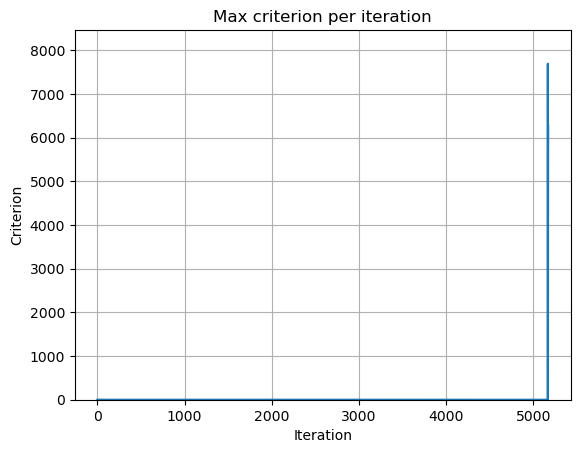

[[1 1 0 ... 1 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [150]:
clusters_v2, crits = bottom_up_clustering_v2(squirells, limit = 30)
print(clusters_v2)

0


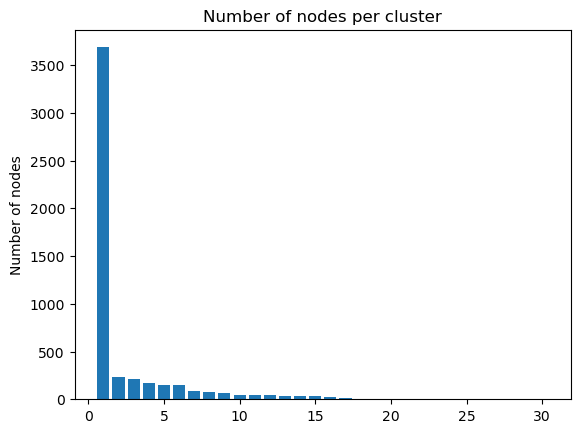

In [151]:
print(number_of_clusters_under(clusters_v2, 2))
plot_cluster_sizes(clusters_v2)

In [ ]:
clusters = bottom_up_clustering(squirells, limit = 30)
print(clusters)

[=>                                                                                                   ]
Iteration 56


KeyboardInterrupt: 

In [ ]:
print(number_of_clusters_under(clusters, 10))
plot_cluster_sizes(clusters)

In [31]:
clusters = np.load("./Clusterings/bottomupv1.npy")

In [ ]:
node_to_cluster = np.argmax(clusters.T == np.arange(n)[:, None], axis=1)

same_cluster_matrix = node_to_cluster[:, None] == node_to_cluster[None, :]
print("Bottom up clustering modularity : ",global_modularity(same_cluster_matrix, clusters, squirells))

Bottom up clustering modularity :  0.9864554417536134


In [48]:
node_to_cluster = np.argmax(clusters_v2.T == np.arange(n)[:, None], axis=1)

same_cluster_matrix = node_to_cluster[:, None] == node_to_cluster[None, :]
print("Bottom up clustering v2 modularity : ",global_modularity(same_cluster_matrix, clusters_v2, squirells))

Bottom up clustering v2 modularity :  0.9864554417536134


In [26]:
pos = nx.spring_layout(squirells)  # Positionnement des nœuds pour la visualisation

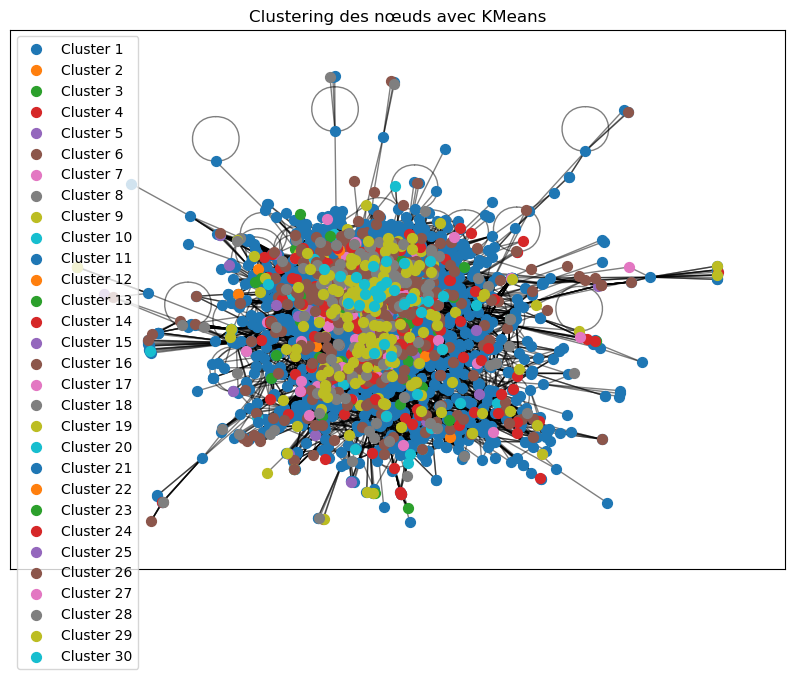

In [152]:
plt.figure(figsize=(10, 7))
for i, cluster in enumerate(clusters_v2):
    nx.draw_networkx_nodes(
        squirells, pos,
        nodelist=[n for n, l in enumerate(cluster) if l == 1],
        node_size=50,  # Ajuster la taille des nœuds
        node_color=f"C{i}",  # Utiliser une couleur différente pour chaque cluster
        label=f"Cluster {i+1}"
    )
nx.draw_networkx_edges(squirells, pos, alpha=0.5)
plt.legend()
plt.title("Clustering des nœuds avec KMeans")
plt.show()

In [155]:
def visualize_clusters_plotly(graph, clusters, title="Visualisation des clusters (Plotly)"):
    """
    Visualise les clusters extraits en coloriant chaque cluster différemment avec Plotly.
    
    Arguments :
        graph : networkx.Graph
            Le graphe à visualiser.
        clusters : list of sets
            Une liste où chaque élément est un ensemble de nœuds appartenant à un cluster.
        title : str
            Le titre du graphique.
    """
    pos = nx.spring_layout(graph, seed=42)  # Disposition des nœuds
    edge_x = []
    edge_y = []

    # Dessiner les arêtes
    for edge in graph.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color="#888"),
        hoverinfo="none",
        mode="lines"
    )

    # Dessiner les nœuds
    node_traces = []
    colors = plt.cm.get_cmap("tab10", len(clusters))
    
    for i, cluster in enumerate(clusters):
        node_x = []
        node_y = []
        for j in range(len(cluster)):
            if cluster[j]==1:
                x, y = pos[j]
                node_x.append(x)
                node_y.append(y)            
        
        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode="markers",
            marker=dict(
                size=10,
                color=f"rgba({int(colors(i)[0]*255)}, {int(colors(i)[1]*255)}, {int(colors(i)[2]*255)}, 0.8)",
                line_width=2
            ),
            name=f"Cluster {i + 1}"
        )
        node_traces.append(node_trace)
    
    # Créer la figure
    fig = go.Figure(data=[edge_trace] + node_traces,
                    layout=go.Layout(
                        title=title,
                        titlefont_size=16,
                        showlegend=True,
                        hovermode="closest",
                        margin=dict(b=0, l=0, r=0, t=40),
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False)
                    ))
    fig.show(renderer="browser")


visualize_clusters_plotly(squirells, clusters_v2)

C:\Users\melvi\AppData\Local\Temp\ipykernel_18016\3025972274.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(clusters))


In [57]:
# Random clustering modularity sanity check

random_clusters = np.random.randint(0, 30, n)
same_cluster_matrix_random = random_clusters[:, None] == random_clusters[None, :]

print("Random assignment clustering modularity : ",global_modularity(same_cluster_matrix_random, random_clusters, squirells))

Random assignment clustering modularity :  -0.15482158060989556


[================================================================================================>    ]
Iteration 33
total clusters 34
Nonempty clusters found: (2, 34)
Superposition nodes: 0


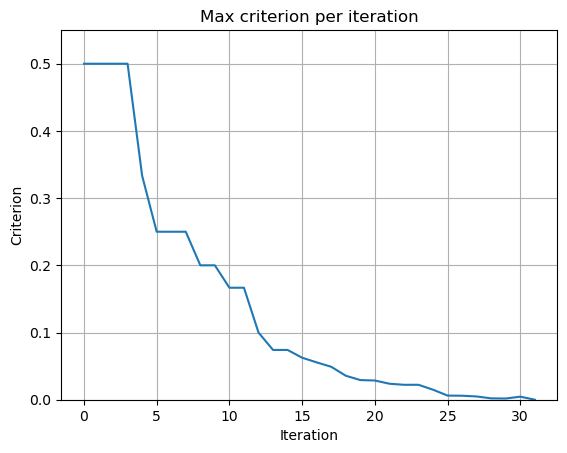

In [159]:
karate = nx.karate_club_graph()

karate_clusters = bottom_up_clustering_v2(karate, limit = 2)[0]


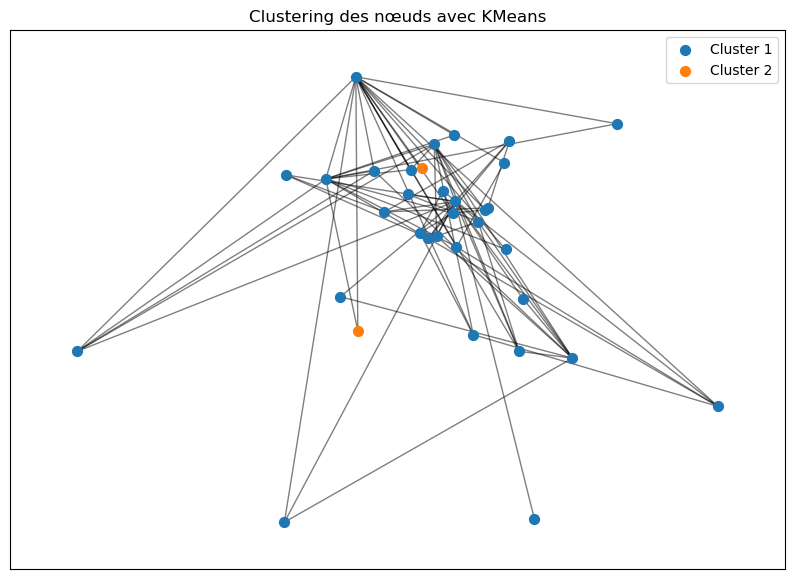

In [160]:
karatepos = nx.spring_layout(karate)
plt.figure(figsize=(10, 7))
for i, cluster in enumerate(karate_clusters):
    nx.draw_networkx_nodes(
        karate, pos,
        nodelist=[n for n, l in enumerate(cluster) if l == 1],
        node_size=50,  # Ajuster la taille des nœuds
        node_color=f"C{i}",  # Utiliser une couleur différente pour chaque cluster
        label=f"Cluster {i+1}"
    )
nx.draw_networkx_edges(karate, pos, alpha=0.5)
plt.legend()
plt.title("Clustering des nœuds avec KMeans")
plt.show()

In [ ]:
#Antoine
#Tiens melnvin tu peux utiliser ce truc pour voir les noms qui ressortent de chaque cluster

from wordcloud import WordCloud

# Combinez toutes les phrases du cluster
text = ' '.join(cluster_phrases).lower()
print(f"Cluster {cluster_id} : {text[:100]}...")

# Générez le Word Cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

# Affichez le Word Cloud
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(f"Word Cloud for Cluster {cluster_id}")
plt.show()